In [7]:
import argparse
from numpy.core.numeric import cross
import yaml
import warnings
import pandas as pd
import glob, os
import logging
from scipy import stats
from typing import Tuple
import tensorflow as tf
import numpy as np                                                         
from utils.data_loader import load_coat, load_synthetic, load_yahoo
from trainer import train_mf, train_mf_kfold, train_expoMF
from evaluate.metrics import evaluator, evaluator_ranking

In [84]:
!pip install matplotlib

  Using cached matplotlib-3.3.4-cp36-cp36m-manylinux1_x86_64.whl (11.5 MB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [8]:
def load_coat() -> Tuple[np.ndarray, np.ndarray]:
    """
    load_coat: Loads coat dataset

    Returns:
        List[np.ndarray, np.ndarray, np.ndarray]: returns train dataframe, test dataframe joined with item feats.
    """    
    train_raw_matrix = np.loadtxt(os.path.join('../data/raw/coat', 'train.ascii'))
    test_raw_matrix = np.loadtxt(os.path.join('../data/raw/coat', 'test.ascii'))
    item_feats = np.loadtxt(os.path.join('../data/raw/coat/user_item_features', 'item_features.ascii'))
    train_df = pd.DataFrame(
        {'uid': np.nonzero(train_raw_matrix)[0].tolist(),
        'pid': np.nonzero(train_raw_matrix)[1].tolist(),
        'rating': train_raw_matrix[np.nonzero(train_raw_matrix)]
        })
    
    test_df = pd.DataFrame(
        {'uid': np.nonzero(test_raw_matrix)[0].tolist(),
        'pid': np.nonzero(test_raw_matrix)[1].tolist(),
        'rating': test_raw_matrix[np.nonzero(test_raw_matrix)]
        })

    col_names = []
    for line in open(os.path.join('../data/raw/coat/user_item_features', 'item_features_map.txt'), 'r'):
        col_names.append(line.strip())
    
    col_name_df = {}
    for i, col_name in enumerate(col_names):
        col_name_df[col_name] = item_feats[:, i]
        col_name_df['pid'] = range(0, item_feats.shape[0])
    
    item_feats_df = pd.DataFrame(col_name_df)
    train_df_item = train_df.merge(item_feats_df, on='pid')
    test_df_item = test_df.merge(item_feats_df, on='pid')

    # Generating user * attribute matrix
    col_names_idx = dict(zip(col_names, range(len(col_names))))
    user_attr_train = np.zeros((train_raw_matrix.shape[0], len(col_names)))
    user_attr_train_count = np.zeros((train_raw_matrix.shape[0], len(col_names)))

    user_attr_test = np.zeros((test_raw_matrix.shape[0], len(col_names)))
    user_attr_test_count = np.zeros((test_raw_matrix.shape[0], len(col_names)))

    for j, row in train_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_train[int(row['uid']), idx] += row['rating']
    
    for j, row in train_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_train_count[int(row['uid']), idx] += 1
            
    for j, row in test_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_test[int(row['uid']), idx] += row['rating']
    
    for j, row in test_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_test_count[int(row['uid']), idx] += 1

    # replace count of ratings with average rating
    user_attr_train /= user_attr_train_count
    user_attr_test /= user_attr_test_count
    # replace division with 0 with -1
    user_attr_train[np.isnan(user_attr_train)] = 0
    user_attr_test[np.isnan(user_attr_test)] = 0
    # Convert float values to nearest int
    user_attr_train = np.ceil(user_attr_train)
    user_attr_test = np.ceil(user_attr_test)

    # train & test user * attribute dataframe
    train_ua_df = pd.DataFrame(
    {'uid': np.nonzero(user_attr_train)[0].tolist(),
     'pid': np.nonzero(user_attr_train)[1].tolist(),
     'rating': user_attr_train[np.nonzero(user_attr_train)]
    })

    # np.random.seed(12345)
    # msk = np.random.rand(len(train_ua_df)) < 0.9
    
    # train_split_df = train_ua_df[msk]
    # valid_split_df = train_ua_df[~msk]


    test_ua_df = pd.DataFrame(
    {'uid': np.nonzero(user_attr_test)[0].tolist(),
     'pid': np.nonzero(user_attr_test)[1].tolist(),
     'rating': user_attr_test[np.nonzero(user_attr_test)]
    })
    np.random.seed(12345)
    msk = np.random.rand(len(test_ua_df)) < 0.8
    
    eval_split_df = test_ua_df[msk]
    prop_split_df = test_ua_df[~msk]

    return (train_df_item, test_df_item, train_ua_df, eval_split_df, prop_split_df, item_feats_df)

In [25]:
config = yaml.safe_load(open('../config/consts.yaml', 'rb'))

In [9]:
res = load_coat()

/home/sgupta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/sgupta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


In [11]:
cross_val_files = glob.glob('../reports/results/cross_val_results_*')

In [13]:
len(cross_val_files)

20

In [14]:
df_results = []
for cross_val_file in cross_val_files:
    df_res = pd.read_csv(cross_val_file, delimiter='\t')
    df_results.append(df_res)
df_params = pd.concat(df_results, ignore_index=True)
print(df_params)

   Dataset  Method  lf_dim  reg_param       MSE
0     COAT      MF      20   0.000001  0.288339
1     COAT  MF-IPS      20   0.000001  0.275247
2     COAT  ExpoMF      20   0.000001  0.911770
3     COAT      MF      40   0.000001  0.280432
4     COAT  MF-IPS      40   0.000001  0.270734
5     COAT  ExpoMF      40   0.000001  0.950467
6     COAT      MF      40   0.000100  0.276840
7     COAT  MF-IPS      40   0.000100  0.272443
8     COAT  ExpoMF      40   0.000100  0.950467
9     COAT      MF       5   0.010000  0.307331
10    COAT  MF-IPS       5   0.010000  0.321628
11    COAT  ExpoMF       5   0.010000  0.391928
12    COAT      MF       5   0.000010  0.292085
13    COAT  MF-IPS       5   0.000010  0.279713
14    COAT  ExpoMF       5   0.000010  0.391928
15    COAT      MF      40   0.001000  0.279734
16    COAT  MF-IPS      40   0.001000  0.269620
17    COAT  ExpoMF      40   0.001000  0.950467
18    COAT      MF      40   0.000010  0.279671
19    COAT  MF-IPS      40   0.000010  0

In [15]:
df_params.columns[0]

'Dataset'

In [16]:
df_params = df_params[df_params['Dataset'] == 'COAT'].reset_index()
df_params_mf = df_params[df_params['Method'] == 'MF'].reset_index()
df_params_mfips = df_params[df_params['Method'] == 'MF-IPS'].reset_index()
df_params_expomf = df_params[df_params['Method'] == 'ExpoMF'].reset_index()

best_param_idx_mf = df_params_mf['MSE'].idxmin()
best_param_idx_mfips = df_params_mfips['MSE'].idxmin()
best_param_idx_expomf = df_params_expomf['MSE'].idxmin()


In [20]:
best_param_idx_expomf

3

In [19]:
df_params_expomf

,level_0,index,Dataset,Method,lf_dim,reg_param,MSE
0,2,2,COAT,ExpoMF,20,0.000001,0.911770
1,5,5,COAT,ExpoMF,40,0.000001,0.950467
2,8,8,COAT,ExpoMF,40,0.000100,0.950467
3,11,11,COAT,ExpoMF,5,0.010000,0.391928
4,14,14,COAT,ExpoMF,5,0.000010,0.391928
5,17,17,COAT,ExpoMF,40,0.001000,0.950467
6,20,20,COAT,ExpoMF,40,0.000010,0.950467
7,23,23,COAT,ExpoMF,10,0.010000,0.567461
8,26,26,COAT,ExpoMF,5,0.000100,0.391928
9,29,29,COAT,ExpoMF,5,0.001000,0.391928


In [21]:
lf_dim_best_mf, reg_param_best_mf = df_params_mf.iloc[best_param_idx_mf]['lf_dim'],\
                                    df_params_mf.iloc[best_param_idx_mf]['reg_param']

lf_dim_best_mfips, reg_param_best_mfips = df_params_mfips.iloc[best_param_idx_mfips]['lf_dim'],\
                            df_params_mfips.iloc[best_param_idx_mfips]['reg_param']

lf_dim_best_expomf, reg_param_best_expomf = df_params_expomf.iloc[best_param_idx_expomf]['lf_dim'],\
                            df_params_expomf.iloc[best_param_idx_expomf]['reg_param']

In [22]:
train_df_item, test_df_item, train_ua_df, test_ua_df, prop_ua_df, item_feats_df = res[0], res[1], res[2], res[3], res[4], res[5]

In [59]:
train_df_item['pid'].max()

299

In [352]:
import pdb
X_test = [test_ua_df[['uid', 'pid']].values[:, 0], test_ua_df[['uid', 'pid']].values[:, 1]]
y_gt = test_ua_df['rating'].values
# train MF plain model
per_dict = {}
per_dict_ips = {}
print("Starting cross-val hyper-param tuning")
#for ulf_dim in ulf_range:
#for ilf_dim in ilf_range:
#for reg_param in reg_param_range:
#ulf_dim = args.user_lf
#reg_param = args.reg_param

maes_mf, mses_mf, maes_mfips, mses_mfips, maes_expomf, mses_expomf = [], [], [], [], [], []
ndcgs_mf, ndcgs_mfips, ndcgs_expomf = [], [], []

logging.info('Starting final %d runs for COAT data to get models performance metric'%(config['runs']))
runs = 10
kurtosis_mf = 0.0
kurtosis_mfips = 0.0
kurtosis_expomf = 0.0
kl_mf = 0.0
kl_mfips = 0.0
kl_expomf = 0.0

for run in range(runs):
    history_mf = train_mf(train_ua_df, test_ua_df, prop_ua_df, \
                ulf_dim=lf_dim_best_mf, ilf_dim=lf_dim_best_mf, reg_param=reg_param_best_mf, \
                ips=0, config=config)
    history_mfips = train_mf(train_ua_df, test_ua_df, prop_ua_df, \
                    ulf_dim=lf_dim_best_mfips, ilf_dim=lf_dim_best_mfips, reg_param=reg_param_best_mfips, \
                        ips=1, config=config)
    history_expomf = train_expoMF(train_ua_df, test_ua_df,  \
                    ulf_dim=lf_dim_best_expomf, reg_param=reg_param_best_expomf, \
                        ips=1, config=config, logging=logging)
    user_topic_scores = (history_mf.model.get_weights()[2] * (history_mf.model.get_weights()[0] @ history_mf.model.get_weights()[1].T) + history_mf.model.get_weights()[3] )
    user_topic_scores_expomf = (history_expomf.theta @ history_expomf.beta.T) 
    user_topic_scores_ips = (history_mfips.model.get_weights()[2] * (history_mfips.model.get_weights()[0] @ history_mfips.model.get_weights()[1].T) + history_mfips.model.get_weights()[3] )
    
    count_mf = Counter((user_topic_scores).argmax(axis=1).flatten())
    count_mf = {k: v for k, v in sorted(count_mf.items(), key=lambda item: item[1])}
    count_mf = np.array(list(count_mf.values()))/ sum(count_mf.values())
    unif_mf = [1/float(len(count_mf))] * len(count_mf)
    #pdb.set_trace()
    kl_mf += sum(kl_div(count_mf, unif_mf))
    
    count_mfips = Counter((user_topic_scores_ips).argmax(axis=1).flatten())
    count_mfips = {k: v for k, v in sorted(count_mfips.items(), key=lambda item: item[1])}
    count_mfips = np.array(list(count_mfips.values()))/ sum(count_mfips.values())
    unif_mfips = [1/float(len(count_mfips))] * len(count_mfips)
    #pdb.set_trace()
    kl_mfips += sum(kl_div(count_mfips, unif_mfips))
    
    count_expomf = Counter((user_topic_scores_expomf).argmax(axis=1).flatten())
    count_expomf = {k: v for k, v in sorted(count_expomf.items(), key=lambda item: item[1])}
    count_expomf = np.array(list(count_expomf.values()))/ sum(count_expomf.values())
    unif_expomf = [1/float(len(count_expomf))] * len(count_expomf)
    #pdb.set_trace()
    kl_expomf += sum(kl_div(count_expomf, unif_expomf))
    
    
    kurtosis_mfips += kurtosis(list(Counter((user_topic_scores_ips).argmax(axis=1).flatten()).values()))
    kurtosis_mf += kurtosis(list(Counter((user_topic_scores+1).argmax(axis=1).flatten()).values()))
    kurtosis_expomf += kurtosis(list(Counter((user_topic_scores_expomf).argmax(axis=1).flatten()).values()))


Starting cross-val hyper-param tuning
Model: "model_116"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_233 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_234 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_232 (Embedding)       (None, 1, 40)        11600       input_233[0][0]                  
__________________________________________________________________________________________________
embedding_233 (Embedding)       (None, 1, 40)        1320        input_234[0][0]                  
____________________________________________________

Model: "model_120"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_241 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_242 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_240 (Embedding)       (None, 1, 40)        11600       input_241[0][0]                  
__________________________________________________________________________________________________
embedding_241 (Embedding)       (None, 1, 40)        1320        input_242[0][0]                  
__________________________________________________________________________________________

Model: "model_124"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_249 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_250 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_248 (Embedding)       (None, 1, 40)        11600       input_249[0][0]                  
__________________________________________________________________________________________________
embedding_249 (Embedding)       (None, 1, 40)        1320        input_250[0][0]                  
__________________________________________________________________________________________

Model: "model_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_257 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_258 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_256 (Embedding)       (None, 1, 40)        11600       input_257[0][0]                  
__________________________________________________________________________________________________
embedding_257 (Embedding)       (None, 1, 40)        1320        input_258[0][0]                  
__________________________________________________________________________________________

Model: "model_132"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_265 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_266 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_264 (Embedding)       (None, 1, 40)        11600       input_265[0][0]                  
__________________________________________________________________________________________________
embedding_265 (Embedding)       (None, 1, 40)        1320        input_266[0][0]                  
__________________________________________________________________________________________

In [353]:
kurtosis([3,1,2])

-1.5

In [354]:
print("Kurtosis-Expomf %f"%(kurtosis_expomf/10))
print("Kurtosis-mf %f"%(kurtosis_mf/10))
print("Kurtosis-mf IPS %f"%(kurtosis_mfips/10))

Kurtosis-Expomf 0.949674
Kurtosis-mf 1.630055
Kurtosis-mf IPS -0.155069


In [355]:
print("kl-Expomf %f"%(kl_expomf/10))
print("KL-mf %f"%(kl_mf/10))
print("KL-mf IPS %f"%(kl_mfips/10))

kl-Expomf 0.470890
KL-mf 0.777804
KL-mf IPS 0.424433


In [318]:
history_mf.history

{'loss': [7.087019443511963,
  1.223165512084961,
  0.8820462822914124,
  0.8666879534721375,
  0.8511831760406494,
  0.826255738735199,
  0.7945048809051514,
  0.7547330260276794,
  0.7128660678863525,
  0.6650223731994629]}

In [319]:
user_topic_scores = (history_mf.model.get_weights()[2] * (history_mf.model.get_weights()[0] @ history_mf.model.get_weights()[1].T) + history_mf.model.get_weights()[3] )

In [320]:
Counter(user_topic_scores.argmax(axis=1).flatten())

Counter({11: 107,
         5: 7,
         19: 53,
         29: 2,
         2: 103,
         10: 3,
         27: 3,
         25: 6,
         4: 5,
         12: 1})

In [321]:
user_topic_scores.argmax(axis=1).shape

(290,)

<BarContainer object of 10 artists>

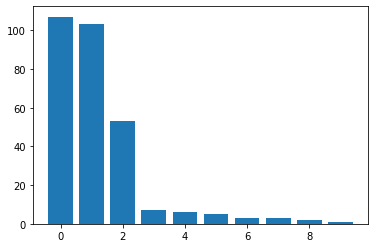

In [322]:
from collections import Counter
#topic_counts = list(Counter(user_topic_scores.astype(np.int).flatten()).values())
topic_counts = list(Counter(user_topic_scores.argmax(axis=1).flatten()).values())
plot.bar(range(len(topic_counts)),sorted(topic_counts, reverse=True),align='center')
#list(Counter(user_topic_scores.argmax(axis=1)).values())

In [323]:
len(Counter((user_topic_scores+1).argmax(axis=1).flatten()))

10

In [324]:
(user_topic_scores_ips+1).argmax(axis=1).shape

(290,)

In [325]:
user_topic_scores_ips = (history_mfips.model.get_weights()[2] * (history_mfips.model.get_weights()[0] @ history_mfips.model.get_weights()[1].T) + history_mfips.model.get_weights()[3] )

<BarContainer object of 8 artists>

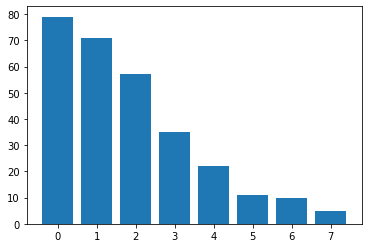

In [326]:
#topic_counts = list(Counter((user_topic_scores_ips+1).astype(np.int).flatten()).values())
topic_counts = list(Counter((user_topic_scores_ips+1).argmax(axis=1).flatten()).values())
plot.bar(range(len(topic_counts)),sorted(topic_counts, reverse=True),align='center')


In [327]:
len(Counter((user_topic_scores_ips+1).argmax(axis=1).flatten()))

8

In [340]:
from scipy.stats import norm, kurtosis
from scipy.special import kl_div

In [329]:
kurtosis(list(Counter((user_topic_scores_ips).argmax(axis=1).flatten()).values()))

-1.4620491781840879

In [330]:
kurtosis(list(Counter((user_topic_scores+1).argmax(axis=1).flatten()).values()))

-0.4479593471742165

In [99]:
Counter(user_topic_scores.argmax(axis=1))

Counter({11: 135, 31: 30, 22: 1, 19: 17, 2: 73, 8: 3, 12: 1, 4: 23, 25: 7})

In [222]:
y_pred_mf = history_mf.model.predict(X_test)
y_pred_mfips = history_mfips.model.predict(X_test)

In [228]:
Counter(y_pred_mf.flatten().astype(np.int))

Counter({3: 1476, 2: 2509, 1: 711, 4: 183, 5: 11})

In [229]:
Counter(y_pred_mfips.flatten().astype(np.int))

Counter({4: 156, 2: 2320, 3: 979, 1: 1399, 0: 24, 5: 12})

AttributeError: 'Line2D' object has no property 'density'

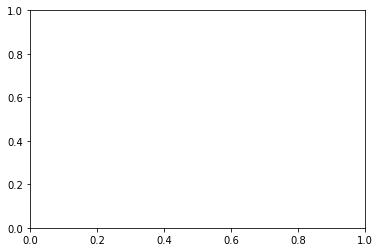

In [113]:
import matplotlib.pyplot as plot

plot.plot(list(Counter(user_topic_scores.argmax(axis=1)).values()),density=1, bins=20) 

In [67]:
col_names = []
for line in open(os.path.join('../data/raw/coat/user_item_features', 'item_features_map.txt'), 'r'):
    col_names.append(line.strip())


In [68]:
col_names

['gender:men',
 'gender:women',
 'jackettype:bomber',
 'jackettype:cropped',
 'jackettype:field',
 'jackettype:fleece',
 'jackettype:insulated',
 'jackettype:motorcycle',
 'jackettype:other',
 'jackettype:packable',
 'jackettype:parkas',
 'jackettype:pea',
 'jackettype:rain',
 'jackettype:shells',
 'jackettype:track',
 'jackettype:trench',
 'jackettype:vests',
 'jackettype:waterproof',
 'color:beige',
 'color:black',
 'color:blue',
 'color:brown',
 'color:gray',
 'color:green',
 'color:multi',
 'color:navy',
 'color:olive',
 'color:other',
 'color:pink',
 'color:purple',
 'color:red',
 'onfrontpage:yes',
 'onfrontpage:no']

In [69]:
item_feats = np.loadtxt(os.path.join('../data/raw/coat/user_item_features', 'item_features.ascii'))

In [82]:
np.where(item_feats.T == 1)

(array([ 0,  0,  0, ..., 32, 32, 32]),
 array([  0,   1,   2, ..., 297, 298, 299]))

In [41]:
y_pred_mf = history_mf.model.predict(X_test)

In [51]:
y_pred_mf.max()

5.536191

In [94]:
history_mf.model.get_weights()

[array([[-0.19978216, -0.1537097 , -0.19424263, ...,  0.17286858,
         -0.25711918,  0.10904978],
        [-0.05090541, -0.03899537, -0.09592912, ...,  0.08447007,
         -0.07513382,  0.14959675],
        [-0.10448894, -0.13059027, -0.10833335, ...,  0.16680837,
          0.04283736,  0.06519396],
        ...,
        [-0.09738317, -0.08344048, -0.16746895, ...,  0.11266895,
          0.16250823,  0.14642015],
        [-0.10171963, -0.07801136, -0.12614352, ...,  0.10504811,
         -0.04448077,  0.14472958],
        [-0.07229791, -0.1351395 , -0.12186116, ...,  0.09137271,
          0.07827122,  0.1677315 ]], dtype=float32),
 array([[-0.3667073 , -0.37699977, -0.31040722, ...,  0.14624433,
         -0.10071659,  0.45431462],
        [-0.15642197, -0.3445183 , -0.35588202, ...,  0.42915514,
         -0.18906666,  0.09793819],
        [-0.33941808, -0.34788367, -0.2758867 , ...,  0.2938753 ,
          0.02278627,  0.420508  ],
        ...,
        [-0.22543044, -0.38158324, -0.2